*Disclaimer: Please don't think this code can be used accurately for medical purposes.... As we only have 115 covid infected PA X-ray Images*


---



In [20]:
from tensorflow.keras.models import Sequential,Model
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import SeparableConv2D
from tensorflow.keras.layers import Input 
from tensorflow.keras import callbacks
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Dense
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
import h5py
import tensorflow 
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
#config = tensorflow.ConfigProto(allow_soft_placement=True)
#config.gpu_options.per_process_gpu_memory_fraction = 0.9
#sess=tensorflow.Session(config=config)
import matplotlib.pyplot as plt
import numpy as np
%tensorflow_version



Currently selected TF version: 2.x
Available versions:
* 1.x
* 2.x


As you can see you require tf 2.X.x for this code to run...
How ever i was able to run in in my tf 1.X so ,, you can try
Although my GTX 1050ti and i5 8300h with 8gb 2666mhz wasn't able to  run my code. That's why I used Google Colab.

In [3]:
#DATA PREPROCESSING
INIT_LR = 1e-4
EPOCHS = 75
BS = 10
train_datagen = ImageDataGenerator(
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        rotation_range=15,
        fill_mode="nearest")

test_datagen = ImageDataGenerator(rescale=1./255)

training_set = train_datagen.flow_from_directory(
        'drive/My Drive/dataset/train',
        target_size=(224, 224),
        batch_size=BS,
        class_mode='categorical')

test_set = test_datagen.flow_from_directory(
        'drive/My Drive/dataset/test',
        target_size=(224, 224),
        batch_size=BS,
        class_mode='categorical')

Found 186 images belonging to 2 classes.
Found 92 images belonging to 2 classes.


As you can See we have 186 images (90 covid and 96 normal) in our Training_set and other are in test set.

**Now we create our model**




In [4]:
#MODEL PREPARATION 
def build_model():
    input_img = Input(shape=(224,224,3), name='ImageInput')
    x = Conv2D(64, (3,3), activation='relu', padding='same', name='Conv1_1')(input_img)
    x = Conv2D(64, (3,3), activation='relu', padding='same', name='Conv1_2')(x)
    x = MaxPooling2D((2,2), name='pool1')(x)
    
    x = SeparableConv2D(128, (3,3), activation='relu', padding='same', name='Conv2_1')(x)
    x = SeparableConv2D(128, (3,3), activation='relu', padding='same', name='Conv2_2')(x)
    x = MaxPooling2D((2,2), name='pool2')(x)
    
    x = SeparableConv2D(256, (3,3), activation='relu', padding='same', name='Conv3_1')(x)
    x = BatchNormalization(name='bn1')(x)
    x = SeparableConv2D(256, (3,3), activation='relu', padding='same', name='Conv3_2')(x)
    x = BatchNormalization(name='bn2')(x)
    x = SeparableConv2D(256, (3,3), activation='relu', padding='same', name='Conv3_3')(x)
    x = MaxPooling2D((2,2), name='pool3')(x)
    
   # x = SeparableConv2D(512, (3,3), activation='relu', padding='same', name='Conv4_1')(x)
   # x = BatchNormalization(name='bn3')(x)
   # x = SeparableConv2D(512, (3,3), activation='relu', padding='same', name='Conv4_2')(x)
   # x = BatchNormalization(name='bn4')(x)
   # x = SeparableConv2D(512, (3,3), activation='relu', padding='same', name='Conv4_3')(x)
    # x = MaxPooling2D((2,2), name='pool4')(x)
    
    x = Flatten(name='flatten')(x)
    x = Dense(512, activation='relu', name='fc1')(x)
    x = Dropout(0.5, name='dropout1')(x)
    x = Dense(128, activation='relu', name='fc2')(x)
    x = Dropout(0.5, name='dropout2')(x)
    x = Dense(2, activation='softmax', name='fc3')(x)
    
    model = Model(inputs=input_img, outputs=x)
    return model
model =  build_model()
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
ImageInput (InputLayer)      [(None, 224, 224, 3)]     0         
_________________________________________________________________
Conv1_1 (Conv2D)             (None, 224, 224, 64)      1792      
_________________________________________________________________
Conv1_2 (Conv2D)             (None, 224, 224, 64)      36928     
_________________________________________________________________
pool1 (MaxPooling2D)         (None, 112, 112, 64)      0         
_________________________________________________________________
Conv2_1 (SeparableConv2D)    (None, 112, 112, 128)     8896      
_________________________________________________________________
Conv2_2 (SeparableConv2D)    (None, 112, 112, 128)     17664     
_________________________________________________________________
pool2 (MaxPooling2D)         (None, 56, 56, 128)       0     

 ABove : We used Seperable Conv2d because it creates overall less parameters.


---
Now we Initialize our weights (Of onlyconvolutional layer from vgg16 imagnet to get features from a immensely large dataset)



In [5]:
#initialision cov2 weights from vgg16 imagenet 
f = h5py.File('drive/My Drive/vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5', 'r')

# Select the layers for which you want to set weight.

w,b = f['block1_conv1']['block1_conv1_W_1:0'], f['block1_conv1']['block1_conv1_b_1:0']
model.layers[1].set_weights = [w,b]

w,b = f['block1_conv2']['block1_conv2_W_1:0'], f['block1_conv2']['block1_conv2_b_1:0']
model.layers[2].set_weights = [w,b]

w,b = f['block2_conv1']['block2_conv1_W_1:0'], f['block2_conv1']['block2_conv1_b_1:0']
model.layers[4].set_weights = [w,b]

w,b = f['block2_conv2']['block2_conv2_W_1:0'], f['block2_conv2']['block2_conv2_b_1:0']
model.layers[5].set_weights = [w,b]

f.close()
model.summary()    

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
ImageInput (InputLayer)      [(None, 224, 224, 3)]     0         
_________________________________________________________________
Conv1_1 (Conv2D)             (None, 224, 224, 64)      1792      
_________________________________________________________________
Conv1_2 (Conv2D)             (None, 224, 224, 64)      36928     
_________________________________________________________________
pool1 (MaxPooling2D)         (None, 112, 112, 64)      0         
_________________________________________________________________
Conv2_1 (SeparableConv2D)    (None, 112, 112, 128)     8896      
_________________________________________________________________
Conv2_2 (SeparableConv2D)    (None, 112, 112, 128)     17664     
_________________________________________________________________
pool2 (MaxPooling2D)         (None, 56, 56, 128)       0     

In [6]:
#Training phase
opt = Adam(lr=0.0001, decay=1e-5)
es = callbacks.EarlyStopping(patience=18)
chkpt = callbacks.ModelCheckpoint(filepath='best_model_todate', save_best_only=True, save_weights_only=False)
model.compile(loss='binary_crossentropy', metrics=['accuracy'],optimizer=opt)
history =model.fit_generator(training_set,steps_per_epoch=186//BS,epochs=EPOCHS,validation_data=test_set,validation_steps=94//BS,callbacks=[es,chkpt])



Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/75
18/18 [==============================] - ETA: 0s - loss: 0.6856 - accuracy: 0.6056WARNING:tensorflow:From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/resource_variable_ops.py:1817: calling BaseResourceVariable.__init__ (from tensorflow.python.ops.resource_variable_ops) with constraint is deprecated and will be removed in a future version.
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: best_model_todate/assets
18/18 [==============================] - 16s 894ms/step - loss: 0.6856 - accuracy: 0.6056 - val_loss: 0.6977 - val_accuracy: 0.2667
Epoch 2/75
18/18 [==============================] - 8s 467ms/step - loss: 0.5690 - accuracy: 0.7670 - val_loss: 0.7308 - val_accuracy: 0.2667
Epoch 3/75
18/18 [==============================] - 9s 474ms/step - loss: 0.3279 - accuracy: 0.8807 - val_loss: 0.9215 - val_accuracy: 0.266

As you can see i used patience=18 which defeated the purpose of early stopping .. so please select accordingly

In [0]:
#model.save("wtfhappened.h5") actually callback already saved the best available accuracy model. :D


Now we shall try our model on some of the images

In [10]:
from tensorflow.keras.preprocessing import image
testimg=image.load_img("/content/1-s2.0-S1684118220300608-main.pdf-001.jpg",target_size=(224, 224))
testimg=image.img_to_array(testimg)
testimg=np.expand_dims(testimg,axis=0)
testimg= testimg/255.0
result1=model.predict(testimg)
print(result1)
print(training_set.class_indices)


[[0.99891806 0.00108197]]
{'covid': 0, 'normal': 1}


99.89% covid ... which is true.

In [15]:
testimg1=image.load_img("/content/NORMAL2-IM-0035-0001.jpeg",target_size=(224, 224))
testimg1=image.img_to_array(testimg1)
testimg1=np.expand_dims(testimg1,axis=0)
testimg1= testimg1/255.0
result=model.predict(testimg1)
print(result)

[[0.00468562 0.99531436]]


99.53% Normal, which is also true. Hence our model shows acceptable responses .

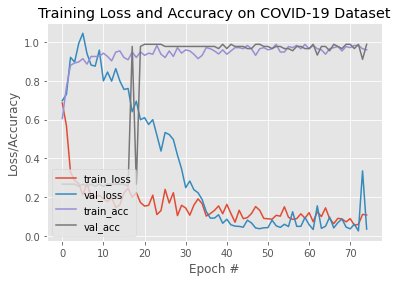

In [19]:
N = EPOCHS
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), history.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), history.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), history.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, N), history.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy on COVID-19 Dataset")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
plt.savefig("plot.jpg")

As you can see there is sudden jump and fall in val accuracies.

# New Section